<a href="https://colab.research.google.com/github/DiogoMondin/comparing_engine_outputs/blob/main/T%26D_comparing_engine_outputs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import kagglehub
import os
import time
import psutil

from pyspark.sql import SparkSession
import pyspark.sql.types as T
import pyspark.sql.functions as F
import pandas as pd
import duckdb
import polars as pl

import matplotlib.pyplot as plt

# Load Dataset

In [2]:
path = kagglehub.dataset_download("microize/newyork-yellow-taxi-trip-data-2020-2019")

for root, dirs, files in os.walk(path):
    for file in files:
        print(os.path.join(root, file))

/kaggle/input/newyork-yellow-taxi-trip-data-2020-2019/yellow_tripdata_2019-10.csv
/kaggle/input/newyork-yellow-taxi-trip-data-2020-2019/yellow_tripdata_2019-02.csv
/kaggle/input/newyork-yellow-taxi-trip-data-2020-2019/yellow_tripdata_2019-03.csv
/kaggle/input/newyork-yellow-taxi-trip-data-2020-2019/yellow_tripdata_2020-04.csv
/kaggle/input/newyork-yellow-taxi-trip-data-2020-2019/taxi+_zone_lookup.csv
/kaggle/input/newyork-yellow-taxi-trip-data-2020-2019/yellow_tripdata_2019-09.csv
/kaggle/input/newyork-yellow-taxi-trip-data-2020-2019/yellow_tripdata_2019-12.csv
/kaggle/input/newyork-yellow-taxi-trip-data-2020-2019/yellow_tripdata_2020-03.csv
/kaggle/input/newyork-yellow-taxi-trip-data-2020-2019/yellow_tripdata_2019-07.csv
/kaggle/input/newyork-yellow-taxi-trip-data-2020-2019/yellow_tripdata_2019-11.csv
/kaggle/input/newyork-yellow-taxi-trip-data-2020-2019/yellow_tripdata_2019-05.csv
/kaggle/input/newyork-yellow-taxi-trip-data-2020-2019/yellow_tripdata_2020-01.csv
/kaggle/input/newyork-

In [3]:
trip_csv = "/kaggle/input/newyork-yellow-taxi-trip-data-2020-2019/yellow_tripdata_2020-06.csv"

# Memory Usage Function

In [4]:
def get_memory_usage_mb():
    process = psutil.Process(os.getpid())
    mem_bytes = process.memory_info().rss  # Resident Set Size
    return mem_bytes / (1024 * 1024)  # Convert to MB

# Data Display

In [5]:
trip_df = pd.read_csv(trip_csv)
trip_df.head()

/tmp/ipython-input-5-4060199421.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  trip_df = pd.read_csv(trip_csv)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1.0,2020-06-01 00:31:23,2020-06-01 00:49:58,1.0,3.6,1.0,N,140,68,1.0,15.5,3.0,0.5,4.00,0.0,0.3,23.30,2.5
1,1.0,2020-06-01 00:42:50,2020-06-01 01:04:33,1.0,5.6,1.0,N,79,226,1.0,19.5,3.0,0.5,2.00,0.0,0.3,25.30,2.5
2,1.0,2020-06-01 00:39:51,2020-06-01 00:49:09,1.0,2.3,1.0,N,238,116,2.0,10.0,0.5,0.5,0.00,0.0,0.3,11.30,0.0
3,1.0,2020-06-01 00:56:13,2020-06-01 01:11:38,1.0,5.3,1.0,N,141,116,2.0,17.5,3.0,0.5,0.00,0.0,0.3,21.30,2.5
4,1.0,2020-06-01 00:16:41,2020-06-01 00:29:30,1.0,4.4,1.0,N,186,75,1.0,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5


# Data Handling - Mean tips per hour

In [6]:
spark = (
    SparkSession.builder
    .appName("NY Taxi Trip Data")
    .getOrCreate()
)

In [7]:
pyspark_trip_df = (
    spark.read
    .option("header", "true")
    .csv(trip_csv)
)

In [8]:
pyspark_mean_tips_per_hour_df = (
    pyspark_trip_df
    .withColumn("tip_amount", F.col("tip_amount").cast(T.DoubleType()))
    .withColumn("tpep_pickup_datetime", F.col("tpep_pickup_datetime").cast(T.TimestampType()))
    .withColumn("hour", F.hour("tpep_pickup_datetime"))
    .groupBy("hour")
    .agg(F.round(F.mean("tip_amount"), 2).alias("mean_tip_amount"))
    .orderBy("hour")
)

pyspark_mean_tips_per_hour_df.show()

+----+---------------+
|hour|mean_tip_amount|
+----+---------------+
|   0|           1.66|
|   1|           0.93|
|   2|           0.64|
|   3|           0.47|
|   4|           0.38|
|   5|           1.12|
|   6|            1.4|
|   7|           1.67|
|   8|           1.73|
|   9|           1.74|
|  10|           1.75|
|  11|           1.68|
|  12|            1.7|
|  13|           1.65|
|  14|           1.68|
|  15|            1.8|
|  16|           1.96|
|  17|           2.07|
|  18|           2.06|
|  19|           1.98|
+----+---------------+
only showing top 20 rows



# Pyspark

In [9]:
mem_before = get_memory_usage_mb()
start_time = time.time()

pyspark_mean_tips_per_hour_df.write.format("delta").mode("overwrite").parquet("/content/spark_output")

mem_after = get_memory_usage_mb()
end_time = time.time()

pyspark_write_time = end_time - start_time
pyspark_mem_usage = mem_after - mem_before

print(f"Total write time: {end_time - start_time:.2f} seconds")
print(f"Memory used for write operation: {mem_after - mem_before:.2f} MB")

Total write time: 4.71 seconds
Memory used for write operation: 0.00 MB


 # Pandas

In [10]:
pandas_mean_tips_per_hour_df = pyspark_mean_tips_per_hour_df.toPandas()

mem_before = get_memory_usage_mb()
start_time = time.time()

pandas_mean_tips_per_hour_df.to_parquet("/content/spark_output.parquet", index=False)

mem_after = get_memory_usage_mb()
end_time = time.time()

pandas_write_time = end_time - start_time
pandas_mem_usage = mem_after - mem_before

print(f"Total write time: {end_time - start_time:.2f} seconds")
print(f"Memory used for write operation: {mem_after - mem_before:.2f} MB")

Total write time: 0.05 seconds
Memory used for write operation: 5.07 MB


# DuckDB

In [11]:
con = duckdb.connect()

con.register("mean_tips_per_hour", pandas_mean_tips_per_hour_df)

mem_before = get_memory_usage_mb()
start_time = time.time()

con.execute("""
    COPY mean_tips_per_hour TO '/content/spark_output_duckdb.parquet' (FORMAT 'parquet')
""")

mem_after = get_memory_usage_mb()
end_time = time.time()

duckdb_write_time = end_time - start_time
duckdb_mem_usage = mem_after - mem_before

print(f"Total write time: {end_time - start_time:.2f} seconds")
print(f"Memory used for write operation: {mem_after - mem_before:.2f} MB")

Total write time: 0.01 seconds
Memory used for write operation: 2.68 MB


# Polars

In [12]:
polars_df = pl.from_pandas(pandas_mean_tips_per_hour_df)

mem_before = get_memory_usage_mb()
start_time = time.time()

polars_df.write_parquet("/content/spark_output_polars.parquet")

mem_after = get_memory_usage_mb()
end_time = time.time()

polars_write_time = end_time - start_time
polars_mem_usage = mem_after - mem_before

print(f"Total write time: {end_time - start_time:.2f} seconds")
print(f"Memory used for write operation: {mem_after - mem_before:.2f} MB")

Total write time: 0.00 seconds
Memory used for write operation: 4.15 MB


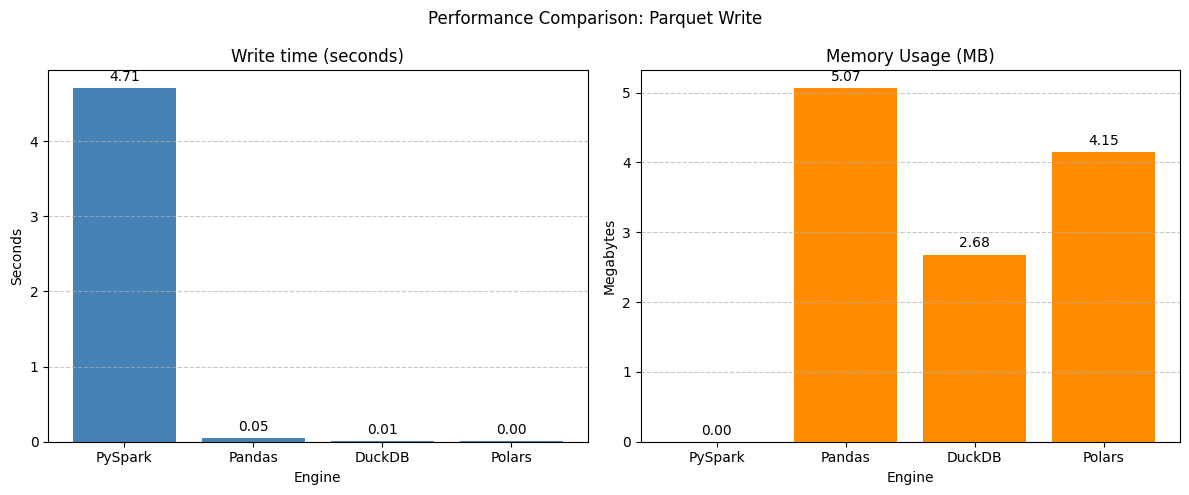

In [13]:
engines = ["PySpark", "Pandas", "DuckDB", "Polars"]
write_times = [pyspark_write_time, pandas_write_time, duckdb_write_time, polars_write_time]
mem_usages = [pyspark_mem_usage, pandas_mem_usage, duckdb_mem_usage, polars_mem_usage]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1 - Write Time
bars1 = axs[0].bar(engines, write_times, color="steelblue")
axs[0].set_title("Write time (seconds)")
axs[0].set_ylabel("Seconds")
axs[0].bar_label(bars1, fmt="%.2f", padding=3)

# Plot 2 - Memory Usage
bars2 = axs[1].bar(engines, mem_usages, color="darkorange")
axs[1].set_title("Memory Usage (MB)")
axs[1].set_ylabel("Megabytes")
axs[1].bar_label(bars2, fmt="%.2f", padding=3)

for ax in axs:
    ax.set_xlabel("Engine")
    ax.set_ylim(bottom=0)
    ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.suptitle("Performance Comparison: Parquet Write")
plt.tight_layout()
plt.show()